In [1]:
# Import packages
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *


In [2]:
# necessary for using the google collab together with the images dataset

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
prefix = "./drive/MyDrive/ML_DATA/deforestation"
#prefix = "."

In [4]:
# load images



## training
training_images_list = os.listdir(r"{}/data/training/images/".format(prefix))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}/data/training/images/{}".format(prefix, n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## trainging masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}/data/training/masks/{}".format(prefix, n))
  training_masks.append(im)

## validation
validation_images_list = os.listdir(r"{}/data/validation/images/".format(prefix))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, n))
  validation_masks.append(im)

## testing
test_images_list = os.listdir(r"{}/data/test/".format(prefix))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}/data/test/{}".format(prefix, n))
  test_images.append(im)


In [5]:
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

for i in range(75,90):
  validation_images.append(training_images[i])
  validation_masks.append(training_masks[i])

training_images = training_images[0:75]
training_masks = training_masks[0:75]

In [6]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

<ipython-input-6-a2e27e58b31c>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_images = np.array(validation_images)
<ipython-input-6-a2e27e58b31c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_masks = np.array(validation_masks)


In [7]:
def learning_curve(history, key='acc', ylim=(0.8, 1.01), model_name=''):
    plt.figure(figsize=(12,6))
    plt.plot(history[key])
    plt.plot(history['accuracy'])
    plt.title('Learning Curve ' + model_name)
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['Loss', 'Accuracy'], loc='best')
    plt.show()

### Custom model

In [8]:
input_shape = (512, 512, 3)

inputs = Input(input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
up1 = UpSampling2D((2, 2))(conv3)
concat1 = Concatenate()([up1, conv2])
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
up2 = UpSampling2D((2, 2))(conv4)
concat2 = Concatenate()([up2, conv1])
outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

Epoch 1/10
5/5 [==============================] - 21s 2s/step - loss: 0.6807 - accuracy: 0.5484
Epoch 2/10
5/5 [==============================] - 2s 374ms/step - loss: 0.5898 - accuracy: 0.8958
Epoch 3/10
5/5 [==============================] - 2s 380ms/step - loss: 0.3877 - accuracy: 0.9067
Epoch 4/10
5/5 [==============================] - 2s 358ms/step - loss: 0.2869 - accuracy: 0.8919
Epoch 5/10
5/5 [==============================] - 2s 368ms/step - loss: 0.2661 - accuracy: 0.8972
Epoch 6/10
5/5 [==============================] - 2s 369ms/step - loss: 0.2537 - accuracy: 0.9175
Epoch 7/10
5/5 [==============================] - 2s 370ms/step - loss: 0.2482 - accuracy: 0.9073
Epoch 8/10
5/5 [==============================] - 2s 368ms/step - loss: 0.2533 - accuracy: 0.9082
Epoch 9/10
5/5 [==============================] - 2s 378ms/step - loss: 0.2156 - accuracy: 0.9165
Epoch 10/10
5/5 [==============================] - 2s 380ms/step - loss: 0.2244 - accuracy: 0.9112


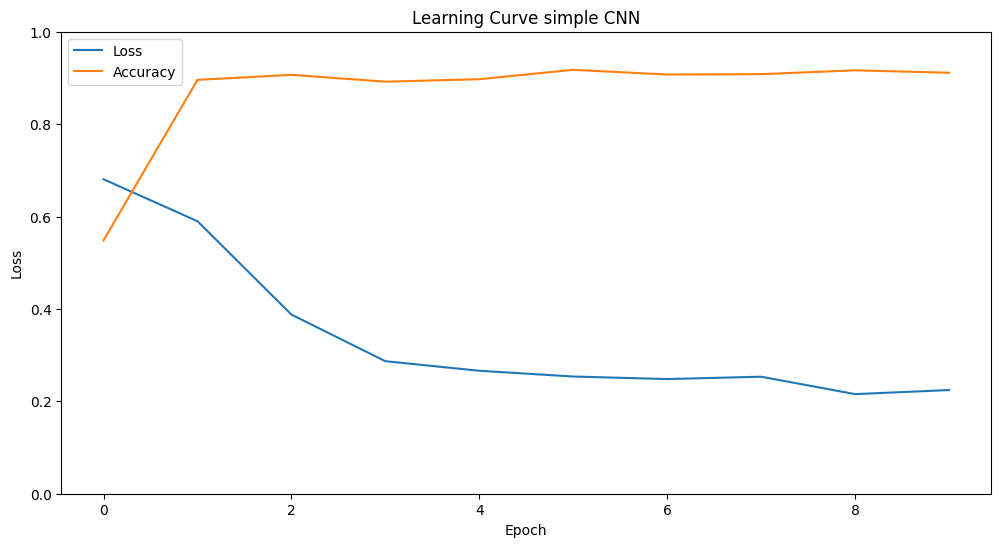

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [9]:
history = model.fit(training_images, training_masks, epochs=10, batch_size=16)

learning_curve(history.history, key='loss', ylim=(0, 1), model_name="simple CNN")
# model.save("{}/models/custom-model/model".format(prefix))

saved_model = tf.keras.models.load_model(r"{}/models/custom-model/model".format(prefix))
saved_model.summary()

metrics = saved_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=4)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

1/1 [==============================] - 0s 119ms/step


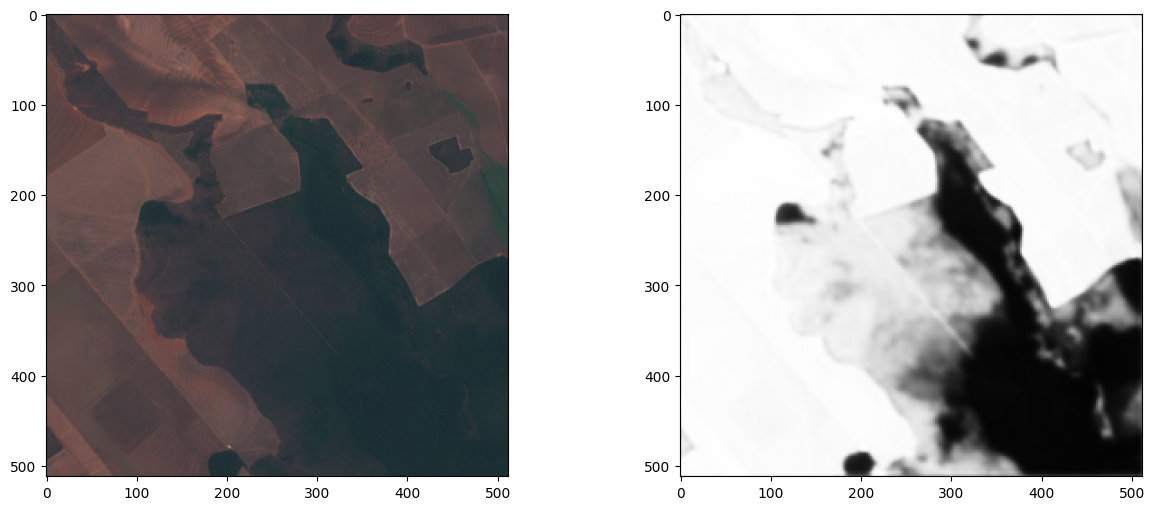

In [10]:
image = PIL.Image.open(r"{}/data/test/{}".format(prefix, test_images_list[1]))
# mask = PIL.Image.open(r"{}/data/testing/masks/{}".format(prefix, test_images_list[0][:-5]+'.png'))

predicted = saved_model.predict(test_images[1])
mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask_image, cmap='gray')


### U-Net

In [11]:
from UNet import UNet

input_shape = (512, 512, 3)
inputs = Input(input_shape, batch_size=1)

uNetModel = UNet(inputs)

uNetModel.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
uNetModel.summary()

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (1, 512, 512, 64)    1792        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (1, 512, 512, 64)    0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (1, 512, 512, 64)    36928       ['activation[0][0]']             
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
75/75 [==============================] - 27s 236ms/step - loss: 0.4922 - accuracy: 0.7564 - mse: 0.1622
Epoch 2/10
75/75 [==============================] - 18s 233ms/step - loss: 0.2300 - accuracy: 0.9213 - mse: 0.0645
Epoch 3/10
75/75 [==============================] - 17s 232ms/step - loss: 0.2232 - accuracy: 0.9177 - mse: 0.0640
Epoch 4/10
75/75 [==============================] - 18s 234ms/step - loss: 0.2087 - accuracy: 0.9330 - mse: 0.0545
Epoch 5/10
75/75 [==============================] - 18s 234ms/step - loss: 0.1788 - accuracy: 0.9318 - mse: 0.0513
Epoch 6/10
75/75 [==============================] - 18s 234ms/step - loss: 0.1818 - accuracy: 0.9359 - mse: 0.0503
Epoch 7/10
75/75 [==============================] - 18s 234ms/step - loss: 0.1714 - accuracy: 0.9341 - mse: 0.0495
Epoch 8/10
75/75 [==============================] - 18s 234ms/step - loss: 0.1624 - accuracy: 0.9387 - mse: 0.0461
Epoch 9/10
75/75 [==============================] - 18s 234ms/step - loss: 0.157

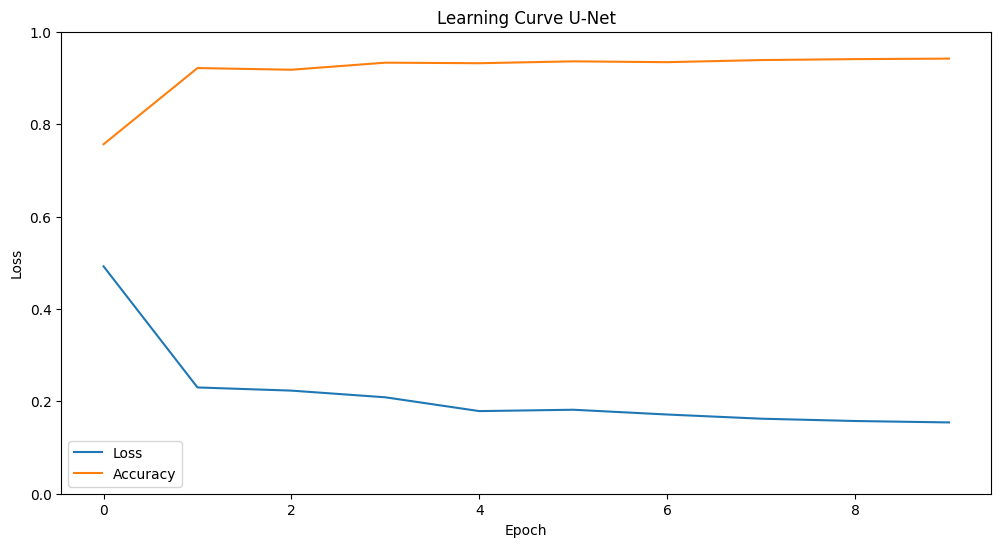

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (1, 512, 512, 64)    1792        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (1, 512, 512, 64)    0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (1, 512, 512, 64)    36928       ['activation[0][0]']             
                                                                                              

In [12]:
history_uNet = uNetModel.fit(training_images, training_masks, epochs=10, batch_size=1)
# uNetModel.save(r"{}/models/u-net/model/".format(prefix))
learning_curve(history_uNet.history, key='loss', ylim=(0, 1), model_name="U-Net")

saved_unet = tf.keras.models.load_model(r"{}/models/u-net/model/".format(prefix))
saved_unet.summary()

metrics = saved_unet.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=4)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

1/1 [==============================] - 0s 247ms/step


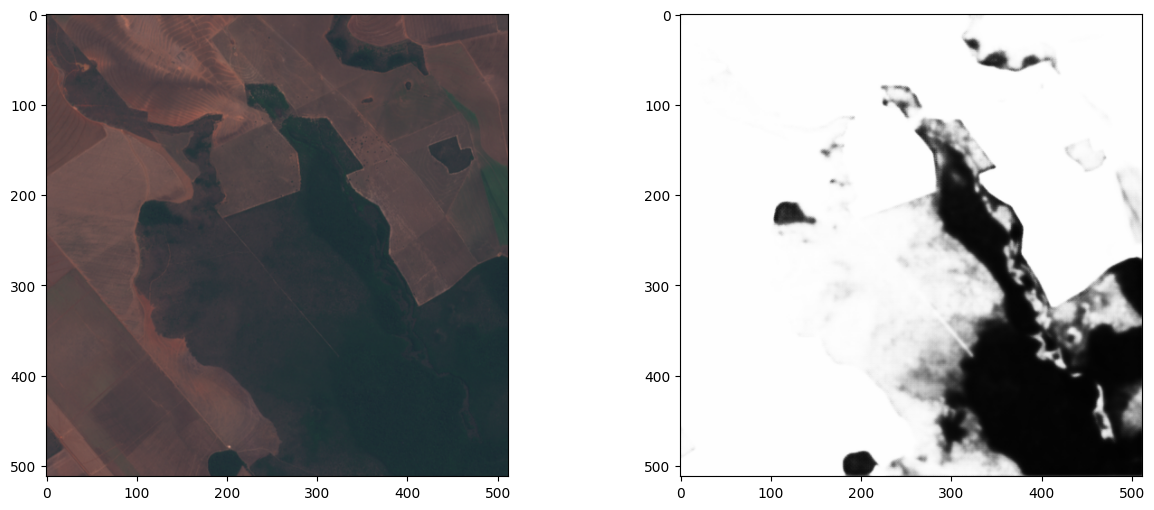

In [13]:
image = PIL.Image.open(r"{}/data/test/{}".format(prefix, test_images_list[1]))
# mask = PIL.Image.open(r"{}/data/testing/masks/{}".format(prefix, test_images_list[0][:-5]+'.png'))

predicted = saved_unet.predict(test_images[1])
mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask_image, cmap='gray')


In [14]:
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### SegNet

In [15]:
from SegNet import SegNet
from focal_loss import BinaryFocalLoss

input_shape = (512, 512, 3)

segNetModel = SegNet(input_shape)

segNetModel.compile(optimizer = Adam(lr = 1e-4), loss = BinaryFocalLoss(gamma=2), metrics = ['accuracy', 'mse'])
segNetModel.summary()

Build encoder done..
Build decoder done..
Model: "seg_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_24[0][0]']              
 alization)                     )                 

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                 (None, 16, 16, 512                                               
                                )]                                                                
                                                                                                  
 max_unpooling2d (MaxUnpooling2  (None, 32, 32, 512)  0          ['max_pooling_with_argmax2d_4[0][
 D)                                                              0]',                             
                                                                  'max_pooling_with_argmax2d_4[0][
                                                                 1]']                             
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 32, 512)  2359808     ['max_unpooling2d[0][0]']        
                                                                                                  
 batch_nor

Epoch 1/5
75/75 [==============================] - 30s 396ms/step - loss: 0.1523 - accuracy: 0.6925 - mse: 0.2154
Epoch 2/5
75/75 [==============================] - 26s 347ms/step - loss: 0.1142 - accuracy: 0.8273 - mse: 0.1726
Epoch 3/5
75/75 [==============================] - 26s 345ms/step - loss: 0.1027 - accuracy: 0.8688 - mse: 0.1599
Epoch 4/5
75/75 [==============================] - 26s 349ms/step - loss: 0.0960 - accuracy: 0.8878 - mse: 0.1539
Epoch 5/5
75/75 [==============================] - 26s 347ms/step - loss: 0.0946 - accuracy: 0.8984 - mse: 0.1528


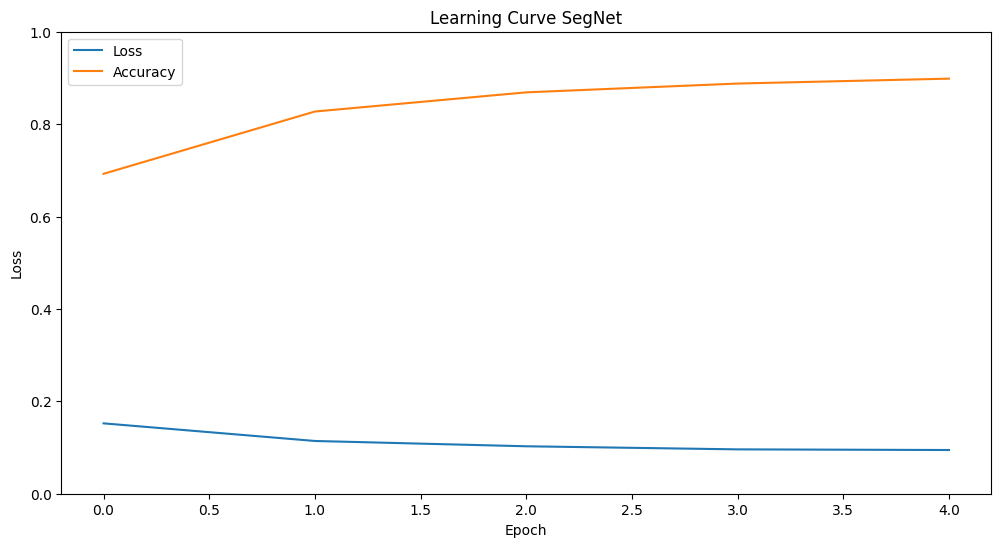

Model: "seg_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_24[0][0]']              
 alization)                     )                                                           

In [17]:
history_segNet = segNetModel.fit(training_images, training_masks, epochs=5, batch_size=1)
segNetModel.save(r"{}/models/seg-net/model/".format(prefix))
learning_curve(history_segNet.history, key='loss', ylim=(0, 1), model_name="SegNet")
saved_segNet = tf.keras.models.load_model(r"{}/models/seg-net/model/".format(prefix))
saved_segNet.summary()

metrics = saved_segNet.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=4)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

1/1 [==============================] - 1s 858ms/step


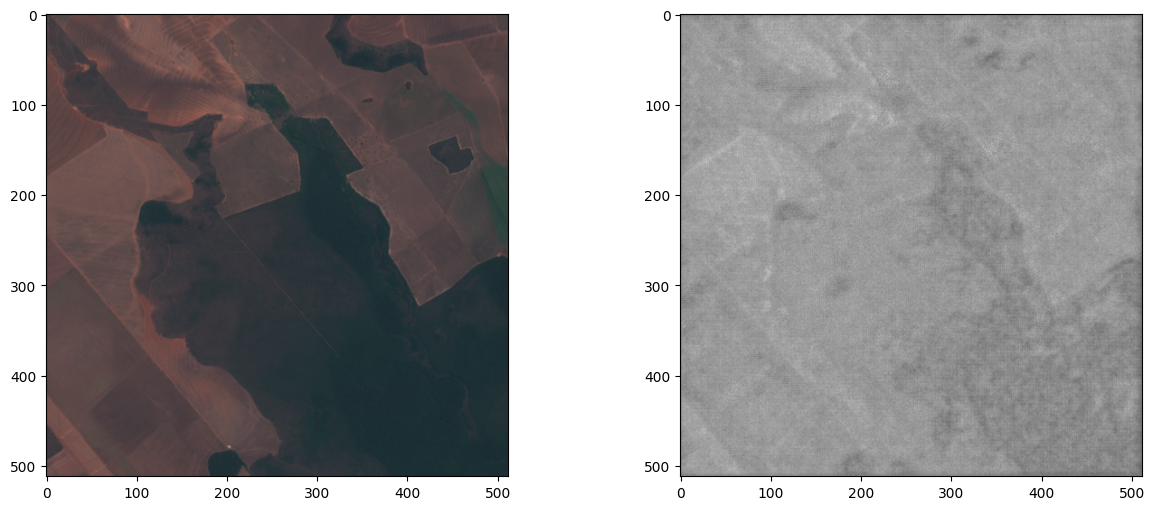

In [18]:
image = PIL.Image.open(r"{}/data/test/{}".format(prefix, test_images_list[1]))
# mask = PIL.Image.open(r"{}/data/testing/masks/{}".format(prefix, test_images_list[0][:-5]+'.png'))

predicted = saved_segNet.predict(test_images[1])
mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask_image, cmap='gray')
